# LGE - SNU AI Scientist 고급과정 [확률통계 및 통계 방법론]
## 5장: 데이터 기반 추론 2
### TA: 홍현경(hyungyeong81@snu.ac.kr)

# 1. Markov Chain Monte Carlo(MCMC)

## 1.1 Gibbs Sampling
$p$차원 모수의 사후분포에 대한 문제가 주어졌을 때, 이를 $p$개의 1차원 모수의 조건부 사후분포로 나누어 Markov Chain을 만들어서 난수를 생성하는 방법이다. **이 때, 1차원 모수의 조건부 사후분포는 난수를 생성하기 쉬운 (우리가 형태를 알고 있는 분포 / known distribution)이다.**\
$p$차원 모수 $\Theta = (\theta_1, \ldots, \theta_p)^T$에 대하여
Gibbs sampling은 $t$번째 확률벡터열 $\Theta^{(t)}$를 다음과 같이 만들 수 있다:


\begin{aligned}
\theta_1^{(t)} &\sim \pi\bigl(\theta_1 \mid \theta_2^{(t-1)}, \theta_3^{(t-1)}, \ldots, \theta_p^{(t-1)}, \text{Data}\bigr),\\
\theta_2^{(t)} &\sim \pi\bigl(\theta_2 \mid \theta_1^{(t)}, \theta_3^{(t-1)}, \ldots, \theta_p^{(t-1)}, \text{Data}\bigr),\\
&\quad \vdots \\
\theta_p^{(t)} &\sim \pi\bigl(\theta_p \mid \theta_1^{(t)}, \theta_2^{(t)}, \ldots, \theta_{p-1}^{(t)}, \text{Data}\bigr).
\end{aligned}

$t = 1, \cdots, T$라고 하면, Gibbs sampling을 통해 다음과 같은 확률벡터열을 구할 수 있다.

\begin{aligned}
\Theta^{(1)} &= (\theta_1^{(1)}, \dots, \theta_p^{(1)})' \\
\Theta^{(2)} &= (\theta_1^{(2)}, \dots, \theta_p^{(2)})' \\
&\quad \vdots \\
\Theta^{(T)} &= (\theta_1^{(T)}, \dots, \theta_p^{(T)})'
\end{aligned}

여기에서, $\Theta^{(t)}$는 주어진 $\Theta^{(t-1)}$에 대하여 $\Theta^{(0)}, \Theta^{(1)}, \dots, \Theta^{(t-2)}$에 조건부 독립이다.

(Gibbs Sampling 예제)

동일한 조건의 실내 공간에서 로봇청소기를 여러 번 작동시키는 상황을 가정하자. 이 때, 각 작동에서 전체 청소 면적 중 실제로 청소가 완료된 비율(%)은 정규분포를 따른다고 한다. 30개의 작동 결과를 랜덤 추출하여 청소가 완료된 비율에 대한 평균과 분산을 Gibbs sampling을 이용하여 추정해보자.


*   청소 완료 비율 데이터: $X_1, \cdots, X_n \overset{i.i.d.}{\sim} N(\mu, \sigma^2)$
*  사전분포: $\pi(\mu) \propto 1, \ \pi(\sigma^2) \propto \frac{1}{\sigma^2}$
*   조건부사후분포:
 \begin{aligned} \mu | \boldsymbol{X}, \sigma^{2} & \sim N\left(\bar{X}, \frac{\sigma^{2}}{n}\right) \\ \sigma^{2} | \boldsymbol{X}, \mu & \sim \text { IGamma }\left(\frac{n}{2}, \frac{1}{2} \sum_{i=1}^{n}\left(X_{i}-\mu\right)^{2}\right) \end{aligned}
 이 때, $\boldsymbol{X} = (X_1,\cdots, X_n)^{'}$

주어진 상황에 대한 Gibbs sampling 알고리즘은 다음과 같다.

\begin{array}{l}
{\text { [1] Initialize } \left( \mu^{(0)}, \sigma^{2(0)}\right)}\\\\
{ \text{For t=1  to T, iterate}} : \\\\
{ \text { [2] } \mu^{(t)} \sim N\left(\bar{X}, \frac{\sigma^{2(t-1)}}{n}\right)}\\
{ \text{ [3] }  \sigma^{2(t)} \sim \text { IGamma }\left(\dfrac{n}{2}, \dfrac{1}{2} \sum_{i=1}^{n} \left(X_{i}-\mu^{(t)}\right)^{2}\right)} \end{array}

편의를 위해 이 예제에서는 $\mu = 95, \ \sigma = 0.5$인 정규분포에서 $30$개의 랜덤샘플을 추출해서 이를 데이터로 보도록 하자.\
Gibbs sampling을 위해서는 모수에 대한 초기값 설정이 필요한데, $\mu^{(0)} = 95, \ \sigma^{2(0)} = 0.3$으로 설정하여 $T = 10000$개의 Gibbs sampler $\left( (\mu^{(t)}, \sigma^{2(t)}), t = 1, \cdots, 10000 \right)$를 생성하자. 이 때, 수렴을 위해 초기의 $5000$개는 버린 후 나머지만을 이용해서 사후분포를 추정하자.

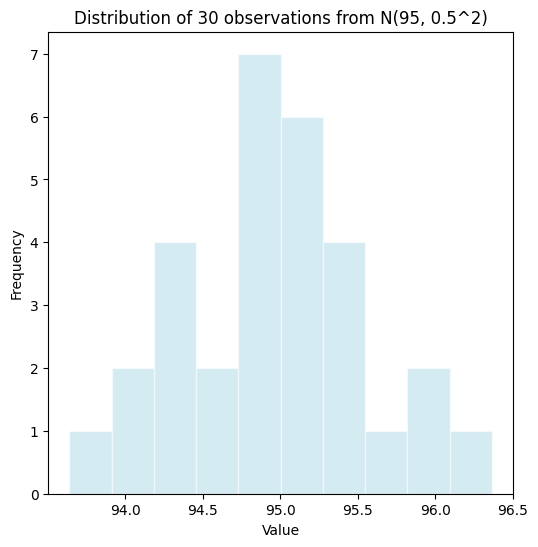

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, invgamma

np.random.seed(2026)

# 데이터 샘플링
n = 30
obs = norm.rvs(95, 0.5, n)

# 데이터에 대한 히스토그램
plt.figure(figsize = (6, 6))
plt.hist(obs, bins = 10, color = "lightblue", alpha = 0.5, edgecolor = 'white')
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of 30 observations from N(95, 0.5^2)")
plt.show()

In [ ]:
mu_init, sigma2_init = 95, 0.3 # 초기값 설정
T = 10000 # sampling size(t = 1, ..., T)
x_bar = obs.mean() # sample mean

# Gibbs sampling
mu_gibbs = []
sigma2_gibbs = []
mu_prev, sigma2_prev = mu_init, sigma2_init

for t in range(T):
  # update mu
  mu_curr = norm.rvs(loc = x_bar, scale = np.sqrt(sigma2_prev / n), size = 1)[0]

  # update sigma2
  beta = sum((obs - mu_curr)**2) / 2
  sigma2_curr = invgamma.rvs(a = n/2, scale = beta, size = 1)[0]

  mu_gibbs.append(mu_curr)
  sigma2_gibbs.append(sigma2_curr)

  mu_prev, sigma2_prev = mu_curr, sigma2_curr

# burn-in을 5000으로 설정
mu_burnin, sigma2_burnin = mu_gibbs[5000: ], sigma2_gibbs[5000:]

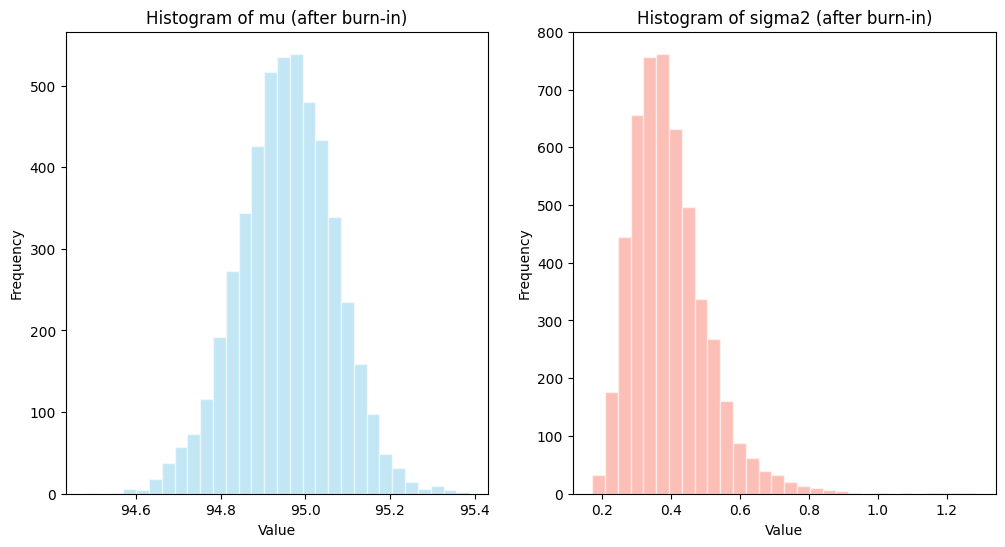

In [ ]:
# mu와 sigma2의 사후 분포를 마지막 5000개의 Gibbs samples에 대한 히스토그램을 이용해서 추정
plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.hist(mu_burnin, bins = 30, color = "skyblue", alpha = 0.5, edgecolor = "white")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of mu (after burn-in)")

plt.subplot(122)
plt.hist(sigma2_burnin, bins = 30, color = "salmon", alpha = 0.5, edgecolor = "white")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of sigma2 (after burn-in)")
plt.show()

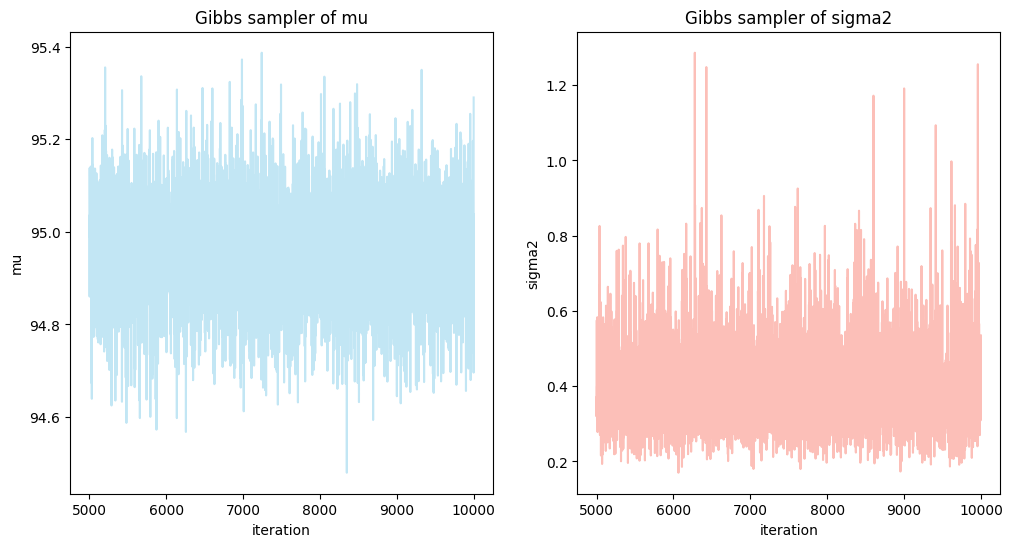

In [ ]:
# 수렴 확인을 위한 trace plot
plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.plot(np.linspace(5001, 10000, 5000), mu_burnin, color = "skyblue", alpha = 0.5)
plt.xlabel("iteration")
plt.ylabel("mu")
plt.title("Gibbs sampler of mu")

plt.subplot(122)
plt.plot(np.linspace(5001, 10000, 5000), sigma2_burnin, color = "salmon", alpha = 0.5)
plt.xlabel("iteration")
plt.ylabel("sigma2")
plt.title("Gibbs sampler of sigma2")
plt.show()

In [ ]:
print("mu: {:.3f}".format(np.mean(mu_burnin)))
print("sigma2: {:.3f}".format(np.mean(sigma2_burnin)))

mu: 94.956
sigma2: 0.394


## 1.2 Metropolis-Hastings Algorithm

1차원 모수의 조건부 사후분포 중 난수 생성이 쉽지 않은 경우가 있다(ex. 조건부 사후분포의 형태가 normal distribution, inverse gamma distribution이 아닌 우리가 알지 못하는 분포의 형태를 보이는 경우). 이러한 상황에서 난수를 생성하기 위해 사용하는 방법이 바로 Metropolis-Hastings algorithm이다.

Metropolis-Hastings algorithm은 다음과 같다.
1. 초기값 $x_0 \ (t = 0)$을 설정한다.

2. 제안분포(proposal distribution) $q(\cdot | X_t)$에서 다음 단계의 후보값(candidate point) $Y$를 랜덤하게 뽑는다.

3. 다음 **acceptance ratio**를 계산하여 Markov Chain의 다음 상태인 $X_{t+1}$을 결정한다.

$$
\alpha \left( X_t, Y\right) = \min \left(1, \dfrac{\pi(Y)q(X_t | Y)}{\pi(X_t)q(Y|X_t)} \right)
$$

4. acceptance / rejection 결정: $\alpha \left( X_t, Y\right)$의 확률로 후보 $Y$가 다음 상태 $X_{t+1}$로 받아들여진다.

$$
\begin{array}{l}
{\text { [1] generate a uniform random number } r \in(0,1)} \\
{\text { [2] if } r \leq \alpha \left( X_t, Y \right), \text { accept the new state and set } X_{t+1} = Y} \\
{\text { [3] if } r > \alpha \left( X_t, Y \right), \text { reject the new state, and copy the old state forward } X_{t+1} = X_{t}}
\end{array}
$$

5. Set $t = t+1$, step 2-5를 반복한다.

(Metropolis-Hastings Algorithm 예제)


*   데이터의 분포: $Y_1, \cdots, Y_N \overset{i.i.d.}{\sim} N(\theta, 1)$
*   $\theta$의 사전분포: $p(\theta) = \frac{1}{\pi(1 + \theta^2)}$ (이 때, $\pi$는 원주율)
*   $\theta$의 사후분포: 베이즈 정리에 의해,
$$
p(\theta | Y_1, \cdots, Y_n) \propto \exp \left( - \dfrac{\sum_{i = 1}^{n}(Y_i - \theta)^2}{2} \right) \times \frac{1}{1 + \theta^2} \propto \exp \left( - \dfrac{n(\theta - \bar{Y})^2}{2} \right) \times \frac{1}{1 + \theta^2}
$$

*   제안분포: 제안분포로는 $N(\bar{Y}, \frac{1}{n})$를 이용한다. 즉,

$$
q(\theta | \theta^{*}) = \frac{1}{\sqrt{2\pi n^{-1}}} \exp \left( - \frac{(\theta - \bar{Y})^2}{2/n} \right)
$$

*   이에 따라 acceptance ratio $\alpha(\theta^{(t-1)}, \tilde{\theta})$는 다음과 같이 설정된다.

$$
\alpha(\theta^{(t-1)}, \tilde{\theta}) = \text{min} \left( 1, \frac{1 + (\theta^{(t-1)})^2}{1 + (\tilde{\theta})^2} \right)
$$

편의를 위해 이 예제에서는 $\theta = 3$으로 설정하여 $N(3, 1)$에서 $100$개의 랜덤샘플을 추출해서 이를 데이터로 보도록 하자.\
Gibbs sampling에서와 마찬가지로 모수에 대한 초기값 설정이 필요한데, $\theta^{(0)} = 1$로 설정하여 $\theta^{(t)} \ (t = 1, \cdots, 10000)$을 생성하자. 이 때, 수렴을 위해 초기의 $9000$개는 버린 후 나머지만을 이용해서 사후분포를 추정하자.

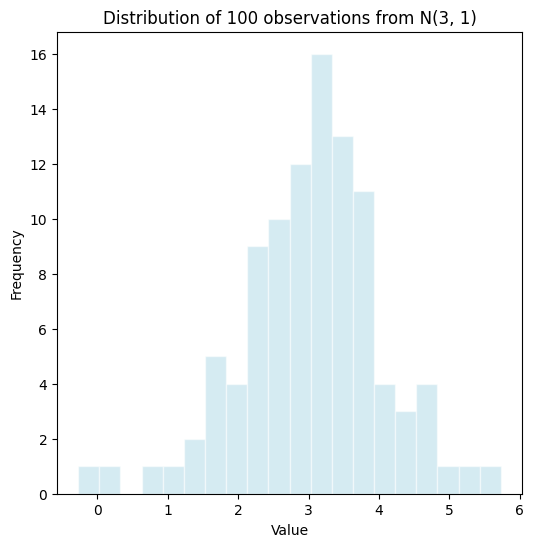

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform

np.random.seed(2026)

# 데이터 샘플링
n = 100
obs = norm.rvs(3, 1, n)

# 데이터에 대한 히스토그램
plt.figure(figsize = (6, 6))
plt.hist(obs, bins = 20, color = "lightblue", alpha = 0.5, edgecolor = "white")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of 100 observations from N(3, 1)")
plt.show()

In [ ]:
theta_init = 1 # 초기값 설정
T = 10000 # sampling size
y_bar = obs.mean() # sample mean

theta_mh = []
theta_prev = theta_init

for t in range(T):
  # 제안분포 N(y_bar, 1/n)에서 샘플링
  theta_candidate = norm.rvs(loc = y_bar, scale = np.sqrt(1/n), size = 1)[0]

  # acceeptance probability
  acceptance_prob = min(1, (1 + theta_prev**2) / (1 + theta_candidate**2))

  # U(0, 1)에서 하나의 난수 생성
  r = uniform.rvs(0, 1, 1)[0]

  if r <= acceptance_prob:
    theta_mh.append(theta_candidate)
    theta_prev = theta_candidate
  else: # r > acceptance_prob
    theta_mh.append(theta_prev)

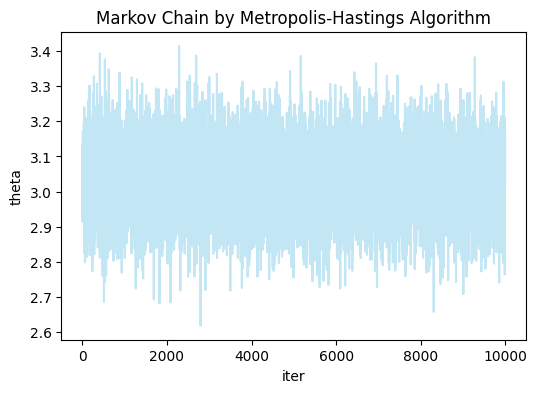

In [ ]:
# 수렴 확인을 위한 trace plot
plt.figure(figsize = (6, 4))
plt.plot(theta_mh, color = "skyblue", alpha = 0.5)
plt.xlabel("iter")
plt.ylabel("theta")
plt.title("Markov Chain by Metropolis-Hastings Algorithm")
plt.show()

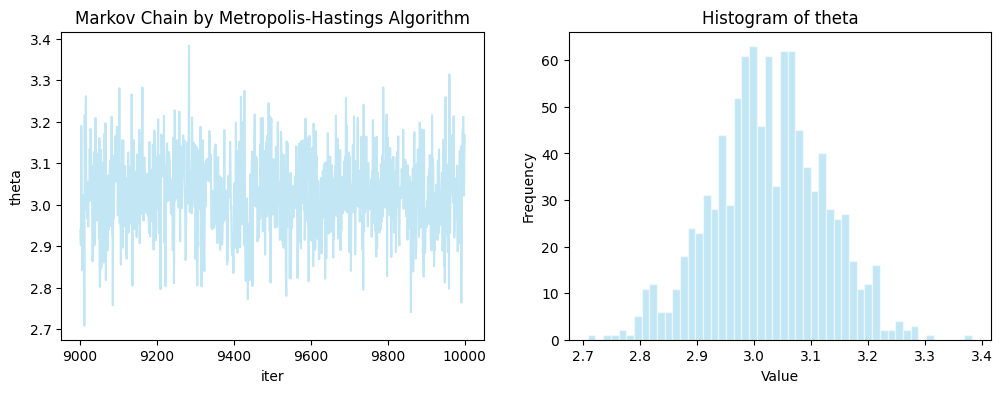

In [ ]:
# burn-in을 9000으로 설정
theta_burnin = theta_mh[9000:]

# burn-in 적용 후 theta의 trace plot과 histogram 확인
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.plot(np.linspace(9001, 10000, 1000), theta_burnin, color = "skyblue", alpha = 0.5)
plt.xlabel("iter")
plt.ylabel("theta")
plt.title("Markov Chain by Metropolis-Hastings Algorithm")

plt.subplot(122)
plt.hist(theta_burnin, bins = 50, color = "skyblue", alpha = 0.5, edgecolor = "white")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of theta")
plt.show()

In [ ]:
# posterior mean estimate
print("posterior mean: {:.3f}".format(np.mean(theta_burnin)))

# posterior median estimate
print("posterior median: {:.3f}".format(np.median(theta_burnin)))

# credible interval
print("credible interval: ({:.3f}, {:.3f})".format(np.percentile(theta_burnin, 2.5), np.percentile(theta_burnin, 97.5)))

posterior mean: 3.024
posterior median: 3.024
credible interval: (2.818, 3.212)


## 1.3 HMC(Hamiltonian Monte Carlo)

- 앞선 Metropolis–Hastings(MH) 예제와 동일한 모형을 두고, 이번에는 HMC(Hamiltonian Monte Carlo)를 이용하여 $\theta$의 사후분포에서 표본을 추출해보자.

-   데이터의 분포: $Y_1, \cdots, Y_N \overset{i.i.d.}{\sim} N(\theta, 1)$
-   $\theta$의 사전분포: $p(\theta) = \frac{1}{\pi(1 + \theta^2)}$ (즉, $\theta \sim \text{Cauchy}(0,1)$)
-   $\theta$의 사후분포: 베이즈 정리에 의해,
$$
p(\theta | Y_1, \cdots, Y_n) \propto \exp \left( - \dfrac{\sum_{i = 1}^{n}(Y_i - \theta)^2}{2} \right) \times \frac{1}{1 + \theta^2} \propto \exp \left( - \dfrac{n(\theta - \bar{Y})^2}{2} \right) \times \frac{1}{1 + \theta^2}
$$

- HMC는 관심 모수 $\theta$를 입자의 위치(position) 로 보고, 보조 변수인
  운동량(momentum) $\eta$를 추가하여 확장된 공간 $(\theta,\eta)$를 구성한다.

- 위치 에너지 $U(\theta)$와 운동 에너지 $K(\eta)$의 합으로 해밀토니안 $H(\theta,\eta)$를 정의하고, 결합분포 $\pi(\theta,\eta) \propto e^{-H(\theta,\eta)}$를 타겟 분포로 설정한다.

- 현재 상태 $(\theta,\eta)$에서 해밀턴 방정식을 따라 파라미터 공간을 연속적으로 이동하며, 이 미분방정식은 Leapfrog 알고리즘을 이용해 수치적으로 근사한다.

- 이동 후에는 에너지 보존 정도에 따라 accept/reject를 수행하고, 운동량 $\eta$는 버린 뒤 $\theta$만을 사후분포의 표본으로 사용한다.

In [ ]:
import numpy as np
import pymc as pm
import arviz as az

np.random.seed(2026)

n = 100
theta_true = 3.0
y = np.random.normal(loc = theta_true, scale = 1.0, size = n)

with pm.Model() as model:
    # prior: Cauchy(0,1)
    theta = pm.Cauchy("theta", alpha = 0.0, beta = 1.0)

    # likelihood: Normal(theta, 1)
    Y = pm.Normal("Y", mu = theta, sigma = 1.0, observed = y)

    # HMC(NUTS)
    idata = pm.sample(
        draws = 2000,
        tune = 1000,
        chains = 4,
        target_accept = 0.9,
        random_seed = 2026
    )

Output()

- HMC를 이용한 추론 결과는 다음과 같다. (참고: M-H algorithm의 사후평균 3.024)

In [ ]:
print(az.summary(idata, var_names = ["theta"], hdi_prob = 0.95))

        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
theta  3.027  0.102     2.838      3.235      0.002    0.001    2677.0   

       ess_tail  r_hat  
theta    4279.0    1.0  


- 이제, 각 파라미터의 사후분포에서 표본이 안정적으로 생성되었는지를 확인하기 위해 trace plot을 확인하자.

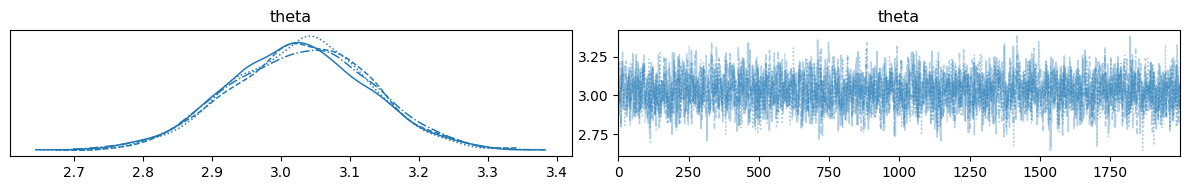

In [ ]:
az.plot_trace(idata, var_names = ["theta"])
plt.tight_layout()
plt.show()

# 2. Variational Inference

* MFVB에 coordinate ascent를 적용하여 ELBO를 최대화하는 방향으로 학습을 진행한다.
* 이 때, 모든 잠재변수들이 서로 독립이라는 mean-field 근사를 가정한다. 이에 따라  $q(\mathbf{z})$는 다음과 같이 표현된다.

\begin{equation*}
q(\mathbf{z}) = \prod_{i=1}^{m}q_i(z_i)
\end{equation*}

* 이때, $q_i(z_i)$는 정규분포, 베르누이분포 등 다양한 분포를 가정한다.
* CAVI의 알고리즘은 다음과 같이 이루어진다.

1. Input: 관측 데이터 $x$, 잠재변수의 수 $m$, 분포 $p(x,z)$
2. Initialize: $q_{i}(z_i)$ for $i=1,\cdots,m$
3. while ELBO has not converged, do
   1. for $i=1,\cdots,m$, do
   
   \begin{equation*}
   q_{i}^{new}(z_i) \propto \exp \left( \mathbb{E}_{-i}\log p(\mathbf{z}, \mathbf{x}) \right)
   \end{equation*}

   2. ELBO 계산 및 수렴 여부 확인

4. end
5. Output: $q_(z)=\prod_{i=1}^{m}q_{i}(z_i)$

Gibbs sampling 예시를 떠올려보자.

*  데이터: $X_1, \cdots, X_n \overset{i.i.d.}{\sim} N(\mu, \sigma^2)$
*  사전분포: $\pi(\mu, \sigma^2) = \pi(\mu) \pi(\sigma^2) \propto \frac{1}{\sigma^2}$
*  조건부사후분포:
 \begin{aligned} \mu | \boldsymbol{X}, \sigma^{2} & \sim N\left(\bar{X}, \frac{\sigma^{2}}{n}\right) \\ \sigma^{2} | \boldsymbol{X}, \mu & \sim \text { IGamma }\left(\frac{n}{2}, \frac{1}{2} \sum_{i=1}^{n}\left(X_{i}-\mu\right)^{2}\right) \end{aligned}
 이 때, $\boldsymbol{X} = (X_1,\cdots, X_n)^{'}$


*   이에 따라, $q(\sigma^2)$가 주어졌을 때 $q^*(\mu)$는,
\begin{eqnarray*}
q^*(\mu) &\propto&  \exp\left(E_{q(\sigma^2)}\left( \log p(\mu| \sigma^2, \mathbf{X})\right) \right)\\
&\propto& \exp\bigg( -\frac{n E_{q(\sigma^2)}[1/\sigma^2]}{2}(\mu-\bar{X})^2\bigg)\\
&\sim& N\left(\bar{X}, \frac{1}{n E_{q(\sigma^2)}[1/\sigma^2]} \right)
\end{eqnarray*}

*   또한, $q(\mu)$가 주어졌을 때 $q^*(\sigma^2)$는,
\begin{eqnarray*}
q^*(\sigma^2) &\propto&  \exp\left(E_{q(\mu)}\left( \log p(\sigma^2| \mu, \boldsymbol{X})\right) \right)\\
&\propto& (\sigma^2)^{-\frac{n}{2}-1}\exp\bigg( -\frac{1}{\sigma^2} \bigg( \frac{\sum_{i = 1}^{n} E_{q(\mu)}(X_i-\mu)^2}{2}\bigg)\bigg)\\
&\sim& \hbox{IGamma} \left(\frac{n}{2}, \frac{\sum_{i = 1}^{n} E_{q(\mu)}(X_i-\mu)^2}{2} \right)
\end{eqnarray*}

*  이제 $q(\mu)=q^*(\mu) = N(\mu_q, \sigma_q^2)$, $q(\sigma)=q^*(\sigma^2) = \hbox{IGamma}(\alpha_q,\beta_q)$로 놓으면 각 모수들은 다음과 같이 계산 가능하다.
  
\begin{eqnarray*}
\mu_q &=& \bar{X}\\
\sigma_q^2 &=&\frac{1}{n E_{q(\sigma^2)}[1/\sigma^2]} = \frac{\beta_q}{n\alpha_q}\\
\alpha_q &=&\frac{n}{2}\\
\beta_q &=&\frac{\sum_{i = 1}^n E_{q(\mu)}(X_i-\mu)^2}{2} =   \frac{n\sigma_q^2 + \sum_{i = 1}^n (X_i-\mu_q)^2}{2}
\end{eqnarray*}

* 이 예시에서 CAVI의 알고리즘은 다음과 같이 이루어진다.

1. $\sigma^2_q$의 초기값을 정한다.
2. ELBO가 수렴할 때 까지 다음을 반복한다.
\begin{eqnarray*}
\mu_q &=& \bar{X} \ \text{(변하지 않음})\\
\alpha_q &=&\frac{n}{2} \ \text{(변하지 않음})\\
\beta_q & \leftarrow &\frac{n\sigma_q^2 + \sum_{i = 1}^n (X_i-\mu_q)^2}{2}\\
\sigma_q^2 & \leftarrow &\frac{\beta_q}{n\alpha_q}\\
\end{eqnarray*}

* 여기에서 ELBO는 다음과 같이 주어지게 된다.
$$
\text{ELBO}(q) = E_q[\log P(X \mid \mu, \sigma^2)] + E_q[\log \pi(\mu, \sigma^2)] - E_q[\log q(\mu)] - E_q[\log q(\sigma^2)],
$$
where
\begin{align*}
-E_q[\log q(\mu)] &= \frac{1}{2} \log \left( 2\pi e \sigma_q^2 \right)\\
-E_q[\log q(\sigma^2)] &= \alpha_q + \log(\beta_q \Gamma(\alpha_q)) - (1 + \alpha_q) \text{digamma}(\alpha_q)\\
E_q[\log p(X \mid \mu, \sigma^2)] &= -\frac{n}{2}\log(2\pi) - \frac{n}{2}E_{q(\sigma^2)}[\log \sigma^2] - \frac{1}{2}E_{q(\sigma^2)}\left[\frac{1}{\sigma^2}\right] \times \left[ n\sigma_q^2 + \sum_{i = 1}^n(X_i - \mu_q)^2 \right]\\
E_q[\log \pi(\mu, \sigma^2)] &= -E_{q(\sigma^2)}[\log \sigma^2]
\end{align*}

  Here, $E_{q(\sigma^2)}[\log \sigma^2] = \log(\beta_q) - \text{digamma}(\alpha_q)$ and $E_{q(\sigma^2)}\left[ \dfrac{1}{\sigma^2} \right]= \dfrac{\alpha_q}{\beta_q}$

* 위의 알고리즘에서 $\beta_q$의 초기값을 먼저 정한 후, $\beta_q$와 $\sigma_q^2$의 업데이트 순서를 바꿔도 무관하다.


앞의 Gibbs sampling 예제와 동일하게 이 예제에서도 $\mu = 95, \ \sigma = 0.5$인 정규분포에서 $30$개의 랜덤샘플을 추출해서 이를 데이터로 보도록 하자.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import digamma, gamma

class CAVI():
  def __init__(self, X, tol = 1e-6, max_iter = 1000):
    # data와 options 저장
    self.X = np.array(X, dtype = float)
    self.n = len(self.X)
    self.tol = tol
    self.max_iter = max_iter

    # data로부터 sample mean, sample variance 계산
    self.xbar = np.mean(self.X)
    self.sample_var = np.mean((self.X - self.xbar)**2)

  def initialize(self):
    # variational parameters 초기화
    self.mu_q = self.xbar
    self.sigma2_q = self.sample_var
    self.alpha_q = self.n / 2
    self.beta_q = 0.5*(self.n * self.sigma2_q + np.sum((self.X - self.mu_q)**2))

  def compute_elbo(self):
    # E[1/sigma^2]
    E_inv_sigma2 = self.alpha_q / self.beta_q

    # E[log(sigma^2)]
    E_log_sigma2 = np.log(self.beta_q) - digamma(self.alpha_q)

    # ELBO를 구성하는 요소들
    term1 = -0.5 * self.n * np.log(2*np.pi) - 0.5 * self.n * E_log_sigma2 - 0.5 * E_inv_sigma2 * (np.sum((self.X - self.mu_q)**2) + self.n * self.sigma2_q)
    term2 = -E_log_sigma2
    term3 = 0.5 * np.log(2 * np.pi * np.e * self.sigma2_q)
    term4 = self.alpha_q + np.log(self.beta_q * gamma(self.alpha_q)) - (1 + self.alpha_q) * digamma(self.alpha_q)

    # 각 요소들을 모두 더하여 최종 ELBO를 구함
    return term1 + term2 + term3 + term4

  def fit(self):
    # 이전의 ELBO값을 None으로 설정
    elbo_prev = None

    # variational parameters 초기화 실행
    self.initialize()

    # ELBO가 수렴할 때 까지 업데이트 반복
    for iteration in range(self.max_iter):
      self.mu_q = self.xbar
      self.sigma2_q = self.beta_q / (self.alpha_q * self.n)
      self.alpha_q = 0.5 * self.n
      self.beta_q = 0.5 * (self.n * self.sigma2_q + np.sum((self.X - self.mu_q)**2))

      elbo_curr = self.compute_elbo()

      if elbo_prev is not None and elbo_curr - elbo_prev < self.tol:
        # 수렴하였으므로 업데이트 종료
        break

      # 수렴하지 않은 경우
      elbo_prev = elbo_curr

  def get_params(self):
    # parameter 값 확인을 위한 메소드
    return(self.mu_q, self.sigma2_q, self.alpha_q, self.beta_q)

In [ ]:
# 데이터 생성
np.random.seed(2026)
mu_true, sigma2_true = 95, 0.25
n = 30
X = norm.rvs(loc = mu_true, scale = np.sqrt(sigma2_true), size = n)

In [ ]:
# 학습 진행
model = CAVI(X)
model.fit()

# 학습을 통해 얻은 variational parameters
mu_q, sigma2_q, alpha_q, beta_q = model.get_params()

# 최종 결과 확인
print("fitted variational parameters:")
print(f"mu_q        = {mu_q:.4f}")
print(f"sigma2_q    = {sigma2_q:.4f}")
print("---------------------")
print(f"alpha_q     = {alpha_q:.4f}")
print(f"beta_q      = {beta_q:.4f}")
print(f"E_q[sigma2] = {beta_q / (alpha_q - 1):.4f}")

fitted variational parameters:
mu_q        = 94.9535
sigma2_q    = 0.0123
---------------------
alpha_q     = 15.0000
beta_q      = 5.5342
E_q[sigma2] = 0.3953


Gibbs sampling 에제와 동일한 데이터로 MFVB로 구한 $q^*(\mu), q^*(\sigma^2)$와 Gibbs sampling으로 구한 $\mu$와 $\sigma^2$의 사후분포를 비교해 보자.

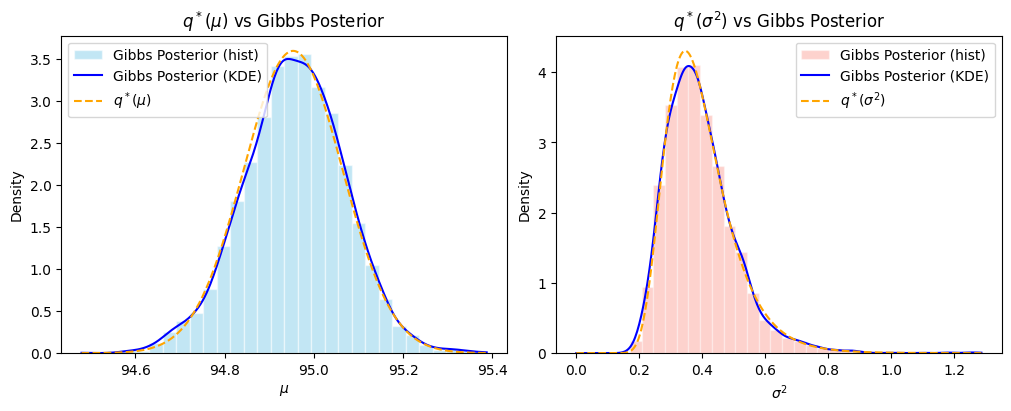

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, invgamma, gaussian_kde

#---------------------
# 기존의 과정과 동일
#---------------------

np.random.seed(2026)

# 데이터 샘플링
n = 30
obs = norm.rvs(95, 0.5, n)

# Gibbs sampling
mu_init, sigma2_init = 95, 0.3
T = 10000
x_bar = obs.mean()

mu_gibbs = []
sigma2_gibbs = []
mu_prev, sigma2_prev = mu_init, sigma2_init

for t in range(T):
  mu_curr = norm.rvs(loc = x_bar, scale = np.sqrt(sigma2_prev / n), size = 1)[0]

  beta = sum((obs - mu_curr)**2) / 2
  sigma2_curr = invgamma.rvs(a = n/2, scale = beta, size = 1)[0]

  mu_gibbs.append(mu_curr)
  sigma2_gibbs.append(sigma2_curr)

  mu_prev, sigma2_prev = mu_curr, sigma2_curr

mu_burnin, sigma2_burnin = np.array(mu_gibbs[5000: ]), np.array(sigma2_gibbs[5000:]) # min, max 계산 위해 numpy array로만 변경

# Coordinate Ascent for MFVB
model = CAVI(obs)
model.fit()

mu_q, sigma2_q, alpha_q, beta_q = model.get_params()

# ----------------
# mu 시각화
# ----------------

mu_q_dist = norm(loc=mu_q, scale=np.sqrt(sigma2_q))
sigma2_q_dist = invgamma(a=alpha_q, scale=beta_q)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

ax = axes[0]
# Gibbs sampling으로 얻은 mu의 히스토그램
ax.hist(mu_burnin, bins=30, density=True, color="skyblue", edgecolor="white", alpha=0.5, label="Gibbs Posterior (hist)")

# Gibbs sampling 사후표본에 대한 KDE
kde_mu = gaussian_kde(mu_burnin)

# mu의 범위 정의
x_mu = np.linspace(mu_burnin.min(), mu_burnin.max(), 400)

# Gibbs posterior (KDE)
ax.plot(x_mu, kde_mu(x_mu), label="Gibbs Posterior (KDE)", color="blue")

# MFVB에서 얻은 q*(mu)
ax.plot(x_mu, mu_q_dist.pdf(x_mu), linestyle="--", label=r"$q^*(\mu)$", color="orange")

ax.set_xlabel(r"$\mu$")
ax.set_ylabel("Density")
ax.set_title(r"$q^*(\mu)$ vs Gibbs Posterior")
ax.legend()

# ----------------
# sigma2 시각화
# ----------------

ax = axes[1]
# Gibbs sampling으로 얻은 sigma^2의 히스토그램
ax.hist(sigma2_burnin, bins=30, density=True, color="salmon", edgecolor="white", alpha=0.35, label="Gibbs Posterior (hist)")

# Gibbs sampling 사후표본에 대한 KDE
kde_s2 = gaussian_kde(sigma2_burnin)

# sigma2의 범위 정의
x_s2 = np.linspace(0, sigma2_burnin.max(), 400)

# Gibbs Posterior (KDE)
ax.plot(x_s2, kde_s2(x_s2), label="Gibbs Posterior (KDE)", color="blue")

# MFVB에서 얻은 q*(sigma^2)
ax.plot(x_s2, sigma2_q_dist.pdf(x_s2), linestyle="--", label=r"$q^*(\sigma^2)$", color="orange")

ax.set_xlabel(r"$\sigma^2$")
ax.set_ylabel("Density")
ax.set_title(r"$q^*(\sigma^2)$ vs Gibbs Posterior")
ax.legend()

plt.show()